In [1]:
!pip install xgboost

     |████████████████████████████████| 297.1MB 1.1MB/s eta 0:00:011     |██████████████████▊             | 173.7MB 62.7MB/s eta 0:00:02
     |████████████████████████████████| 17.3MB 33.1MB/s eta 0:00:01
     |████████████████████████████████| 34.5MB 48.4MB/s eta 0:00:01
ERROR: snowflake-ml-python 1.0.1 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement snowflake-snowpark-python<2,>=1.4.0, but you'll have snowflake-snowpark-python 1.0.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement xgboost<2,>=1.7.3, but you'll have xgboost 2.0.3 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install catboost

     |████████████████████████████████| 98.2MB 43.6MB/s eta 0:00:01
     |████████████████████████████████| 34.5MB 49.0MB/s eta 0:00:01
     |████████████████████████████████| 51kB 42.7MB/s eta 0:00:01
     |████████████████████████████████| 16.4MB 38.6MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 43.8MB/s eta 0:00:01
     |████████████████████████████████| 9.2MB 50.7MB/s eta 0:00:01
     |████████████████████████████████| 12.4MB 37.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 46.3MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 40.3MB/s eta 0:00:01
     |████████████████████████████████| 235kB 51.5MB/s eta 0:00:01
     |████████████████████████████████| 307kB 50.3MB/s eta 0:00:01
     |████████████████████████████████| 4.7MB 35.3MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 36.4MB/s eta 0:00:01
     |████████████████████████████████| 112kB 51.8MB/s eta 0:00:01
     |████████████████████████████████| 348kB 46.5MB/s eta 

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from snowflake.snowpark import Session
import configparser

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
import gc

# Code to establish connection and read data from Snowflake

In [3]:
config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

['snowflake_connection.ini']

In [4]:
connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    #"password": os.getenv('snowflake_password'),
    "account": f'{config["Snowflake"]["account"]}',
    #"account": os.getenv('snowflake_account'),
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

In [5]:
def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

connection successful!


In [6]:
application_train_sf  = session.table("CRA_APPLICATION_TRAIN_DETAILS")
application_test_sf  = session.table("CRA_APPLICATION_TEST_DETAILS")
previous_application_sf  = session.table("CRA_PREVIOUS_APPLICATION_DETAILS")

# Convert Snowflake data into Pandas dataframes

In [7]:
data = application_train_sf.to_pandas()
test = application_test_sf.to_pandas()
prev = previous_application_sf.to_pandas()

In [8]:
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

In [9]:
for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])

In [10]:
gc.enable()

y_train = data['TARGET']
del data['TARGET']

In [11]:
prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]
for f_ in prev_cat_features:
    prev[f_], _ = pd.factorize(prev[f_])

In [12]:
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

In [13]:
x_train = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
x_test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

x_train = x_train.fillna(0)
x_test= x_test.fillna(0)

ntrain = x_train.shape[0]
ntest = x_test.shape[0]

In [14]:
excluded_feats = ['SK_ID_CURR','CREATED_BY','CREATED_AT']
features = [f_ for f_ in x_train.columns if f_ not in excluded_feats]

In [15]:
x_train = x_train[features]
x_test = x_test[features]

kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

NameError: name 'NFOLDS' is not defined

In [37]:
key_prev = 'SK_ID_PREV'
payment_cols = ['AMT_PAYMENT']

# Min payment for all previous loans
df_previous_app = pd.merge(
    left=df_previous_app,
    right=df_installments[[key_prev] + payment_cols].groupby(key_prev).min(),
    left_on=key_prev,
    right_index=True,
    how='left'
)

# Example: SK_ID_CURR #365597
df_previous_app[[key] + [key_prev] + payment_cols][df_previous_app.SK_ID_CURR == 365597]

,SK_ID_CURR,SK_ID_PREV,AMT_PAYMENT
1531913,365597,2027447,14459.94
1616475,365597,1459607,5489.73


In [38]:
df_previous_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'CREATED_BY', 'CREATED_AT', 'AMT_PAYMENT'],
      dtype='object')

In [39]:
key = 'SK_ID_CURR'
prev_agg_cols = ['PREV_SUM_MIN_AMT_PAYMENT', 'PREV_MEAN_MIN_AMT_PAYMENT']

# Sum and mean of minimum payments across all previous loans
df_prev_agg = df_previous_app[[key] + payment_cols].groupby(key).agg(['sum', 'mean']);
df_prev_agg.columns = prev_agg_cols

df = pd.merge(
    left=df,
    right=df_prev_agg,
    left_on=key,
    right_index=True,
    how='left'
)

# Example: SK_ID_CURR #365597
df[[key] + prev_agg_cols][df.SK_ID_CURR == 365597]

,SK_ID_CURR,PREV_SUM_MIN_AMT_PAYMENT,PREV_MEAN_MIN_AMT_PAYMENT
211021,365597,19949.67,9974.835


In [40]:
base_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY',
                'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH',
                'OWN_CAR_AGE'
               ]
feature_cols = base_cols + bureau_cols_max + prev_agg_cols
y = df.TARGET
X = df[feature_cols]
X = X.fillna(value=X.mean())

# Example: SK_ID_CURR #365597
X[df.SK_ID_CURR == 365597].transpose()

,211021
EXT_SOURCE_1,0.589340
EXT_SOURCE_2,0.507737
EXT_SOURCE_3,0.710674
DAYS_BIRTH,-10240.000000
AMT_CREDIT,152820.000000
AMT_ANNUITY,15241.500000
DAYS_EMPLOYED,-543.000000
AMT_GOODS_PRICE,135000.000000
DAYS_ID_PUBLISH,-355.000000
OWN_CAR_AGE,3.000000


In [49]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [50]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

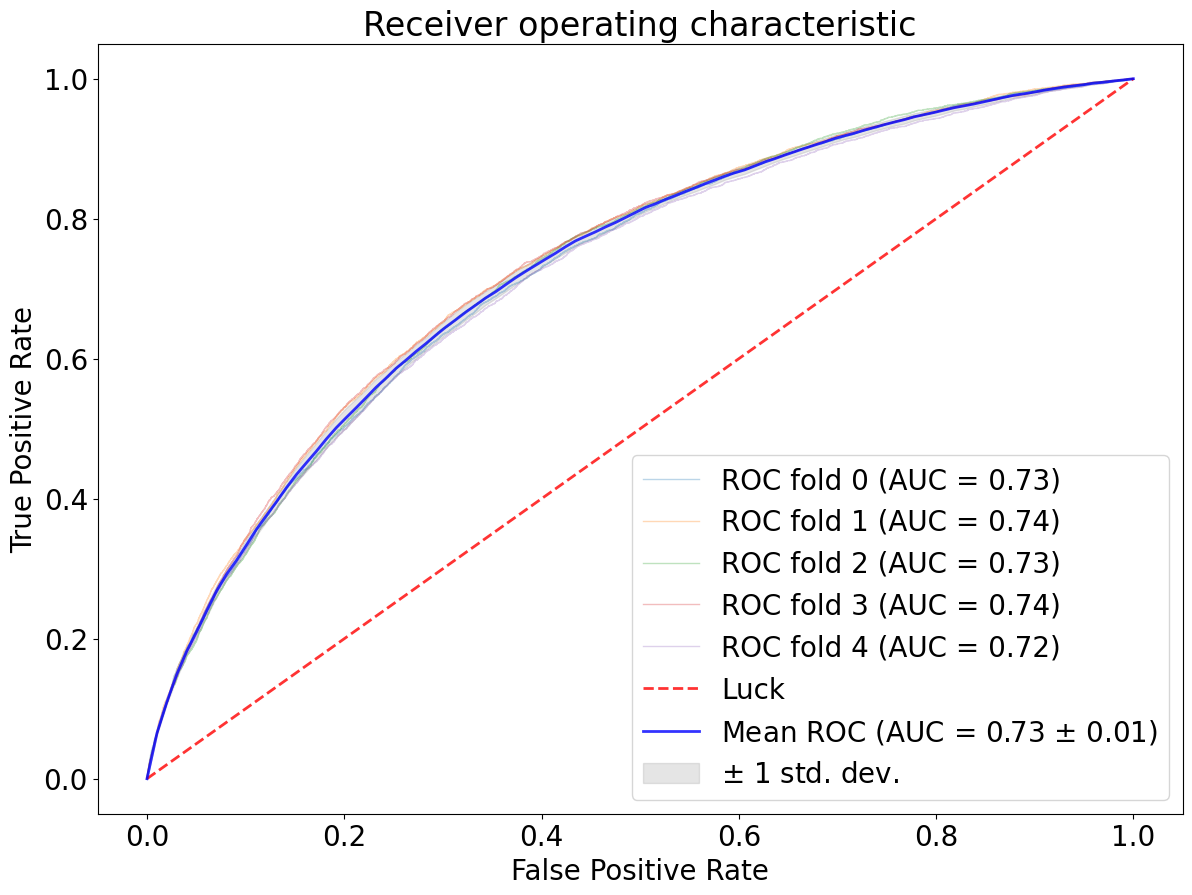

,AUC Train,AUC Test
0,0.737653,0.727166
1,0.736174,0.736660
2,0.736375,0.730861
3,0.736603,0.735803
4,0.736656,0.721448


In [51]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.loc[train], y.loc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])